In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from numpy import linalg as LA

In [70]:
# img1=Image.open('./sheet1.jpg')
# img2=Image.open('./sheet2.jpg')
img1=Image.open('./i1.jpeg')
img2=Image.open('./i1.jpeg')

In [71]:
orig_image = np.array(img1)
skewed_image = np.array(img2)

try:
    surf = cv2.xfeatures2d.SURF_create(500)
except Exception:
    surf = cv2.SIFT(500)
    
kp1,des1 = surf.detectAndCompute(orig_image, None)
kp2,des2 = surf.detectAndCompute(skewed_image, None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

MIN_MATCH_COUNT = 12
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

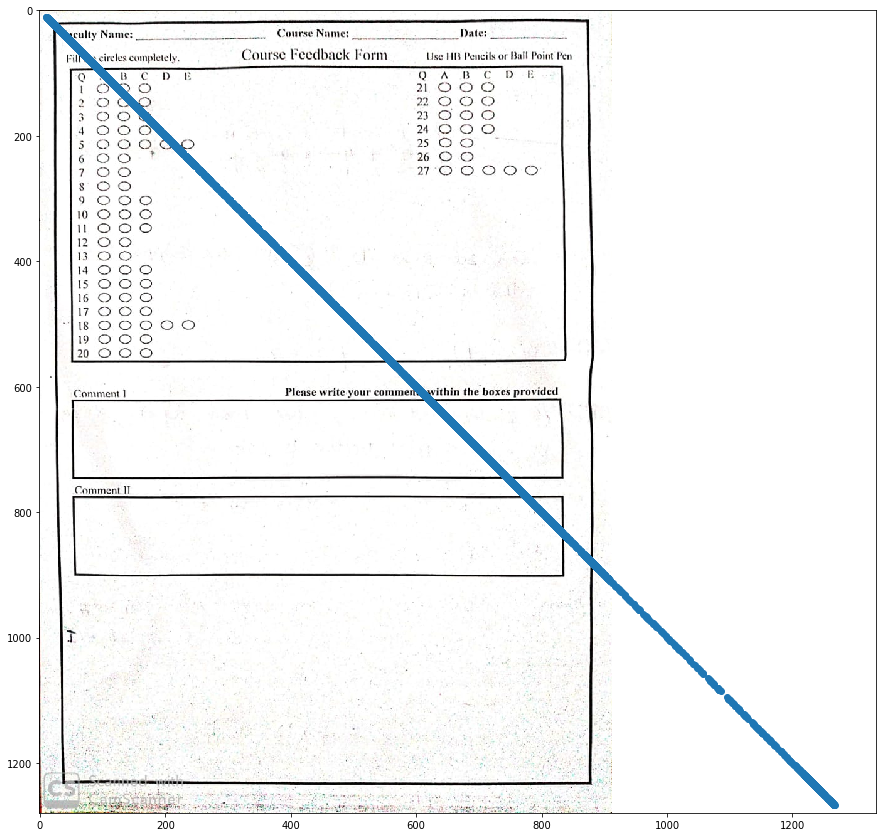

In [72]:
#print(H)
plt.figure(figsize=(15,15))
plt.imshow(orig_image)
plt.scatter(src_pts,dst_pts)
plt.show()

(1220, 1046, 3)
(1220, 1046, 3)


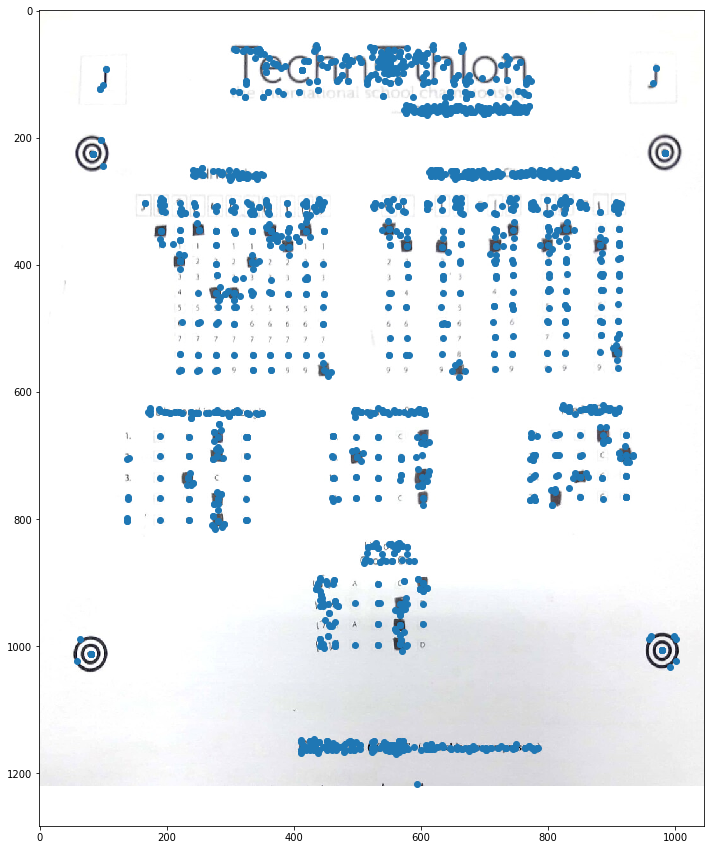

In [69]:
# img1=Image.open('./i1.jpeg')
# img2=Image.open('./i2.jpeg')
img1=Image.open('./sheet1.jpg')
img2=Image.open('./sheet1.jpg')
a=np.array(img1)
b=np.array(img2)
print(a.shape)
print(b.shape)
sift=cv2.xfeatures2d.SIFT_create()
key_points=sift.detect(a)
pts1=np.array([x.pt for x in key_points],dtype=np.float32)
#print(pts1)
pts2,status,_=cv2.calcOpticalFlowPyrLK(a,b,pts1,None)
status=status.reshape(status.shape[0])
pts1=pts1[status == 1]
pts2=pts2[status == 1]
#print(H)
plt.figure(figsize=(15,15))
plt.imshow(a)
plt.scatter(pts1[:,0],pts1[:,1])
plt.show()

In [76]:
def homography(img1, img2, visualize=False):
    """
    Finds Homography matrix from Image1 to Image2.
        Two images should be a plane and can change in viewpoint

    :param img1: Source image
    :param img2: Target image
    :param visualize: Flag to visualize the matched pixels and Homography warping
    :return: Homography matrix. (or) Homography matrix, Visualization image - if visualize is True
    """
    sift = cv.xfeatures2d.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(img1, None)
    kp2, desc2 = sift.detectAndCompute(img2, None)

    index_params = dict(algorithm=FLANN_INDEX_KDTREE)
    # number of times the trees in the index should be recursively traversed
    # Higher values gives better precision, but also takes more time
    sch_params = dict(checks=SCH_PARAM_CHECKS)
    flann = cv.FlannBasedMatcher(index_params, sch_params)

    matches = flann.knnMatch(desc1, desc2, k=2)
    logging.debug('{} matches found'.format(len(matches)))

    # select good matches
    matches_arr = []
    good_matches = []
    for m, n in matches:
        if m.distance < GOOD_MATCH_THRESHOLD * n.distance:
            good_matches.append(m)
        matches_arr.append(m)

    if len(good_matches) < MIN_MATCH_COUNT:
        raise (Exception('Not enough matches found'))
    else:
        logging.debug('{} of {} are good matches'.format(len(good_matches), len(matches)))

    src_pts = [kp1[m.queryIdx].pt for m in good_matches]
    src_pts = np.array(src_pts, dtype=np.float32).reshape((-1, 1, 2))
    dst_pts = [kp2[m.trainIdx].pt for m in good_matches]
    dst_pts = np.array(dst_pts, dtype=np.float32).reshape((-1, 1, 2))

    homo, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5)

    if visualize:
        res = visualize_homo(img1, img2, kp1, kp2, matches, homo, mask)
        return homo, res

    return homo 

In [77]:
img1=Image.open('./i1.jpeg')
img2=Image.open('./i2.jpeg')
print(homography(np.array(img1),np.array(img2),False))

NameError: name 'SCH_PARAM_CHECKS' is not defined

In [78]:
def find_correspondence_points(img1, img2):
    sift = cv2.xfeatures2d.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(
        cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = sift.detectAndCompute(
        cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

    # Find point matches
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's SIFT matching ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

    src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
    dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

    # Constrain matches to fit homography
    retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
    mask = mask.ravel()

    # We select only inlier points
    pts1 = src_pts[mask == 1]
    pts2 = dst_pts[mask == 1]

    return pts1.T, pts2.T 

In [79]:
a,b=find_correspondence_points(np.array(img1),np.array(img2))

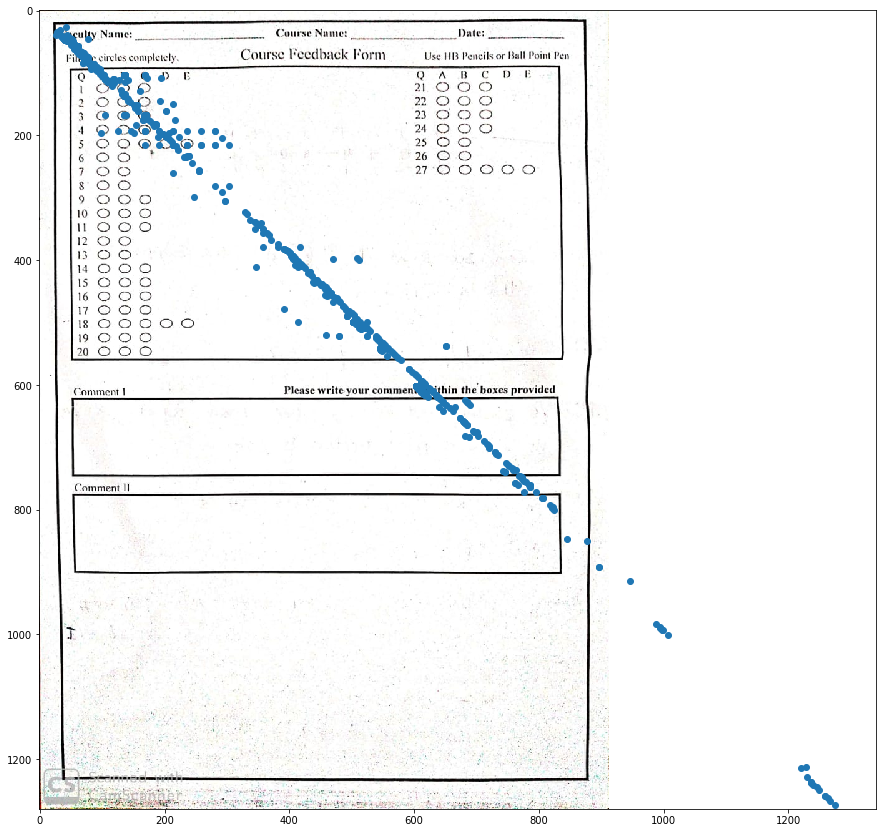

In [82]:
plt.figure(figsize=(15,15))
plt.imshow(np.array(img1))
plt.scatter(a,b)
plt.show()